In [31]:
pip install pandas matplotlib seaborn wordcloud nltk scikit-learn textblob scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
pip install imbalanced-learn

   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/258.3 kB 1.3 MB/s eta 0:00:01
   ------ -------------------------------- 41.0/258.3 kB 960.0 kB/s eta 0:00:01
   ------------ -------------------------- 81.9/258.3 kB 762.6 kB/s eta 0:00:01
   ---------------- --------------------- 112.6/258.3 kB 930.9 kB/s eta 0:00:01
   ------------------- ------------------ 133.1/258.3 kB 653.6 kB/s eta 0:00:01
   ---------------------------- --------- 194.6/258.3 kB 784.3 kB/s eta 0:00:01
   ------------------------------------ - 245.8/258.3 kB 793.0 kB/s eta 0:00:01
   -------------------------------------- 258.3/258.3 kB 754.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
import scipy.sparse as sp

In [36]:
# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Initialize lemmatizer, stemmer, and stopwords
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stopwords = set(nltk_stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'^RT[\s]+', '', text)
        words = word_tokenize(text)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
        return " ".join(words)
    else:
        return ''

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
# Load the dataset
df = pd.read_csv('../data/twitter_training.csv', usecols=[2, 3], header=None, names=['sentiment', 'text'])

In [38]:
# Drop missing values and remove duplicates
df.dropna(subset=['text'], inplace=True)
df.drop_duplicates(subset=['text'], inplace=True)

# Ensure all text entries are strings and preprocess them
df['text'] = df['text'].astype(str)
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 69491 entries, 0 to 74681
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sentiment     69491 non-null  object
 1   text          69491 non-null  object
 2   cleaned_text  69491 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB
None


In [39]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       sentiment                                               text  \
count      69491                                              69491   
unique         4                                              69491   
top     Negative  im getting on borderlands and i will murder yo...   
freq       21166                                                  1   

       cleaned_text  
count         69491  
unique        61394  
top                  
freq            333  


In [40]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
sentiment       0
text            0
cleaned_text    0
dtype: int64


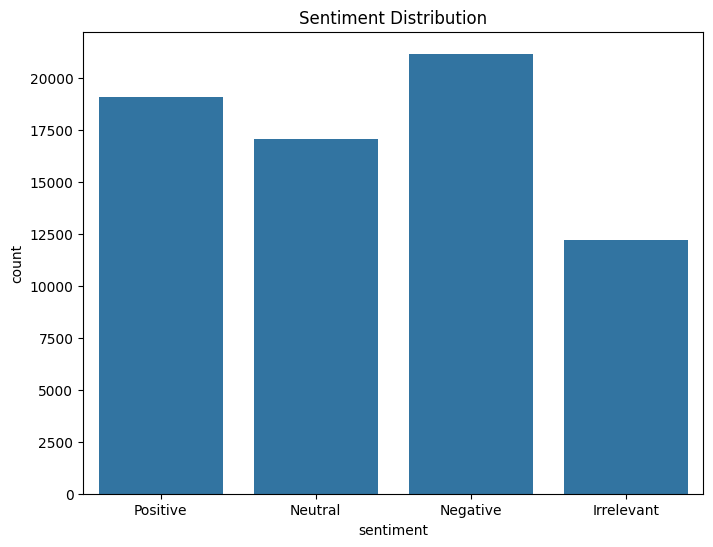

In [41]:
# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

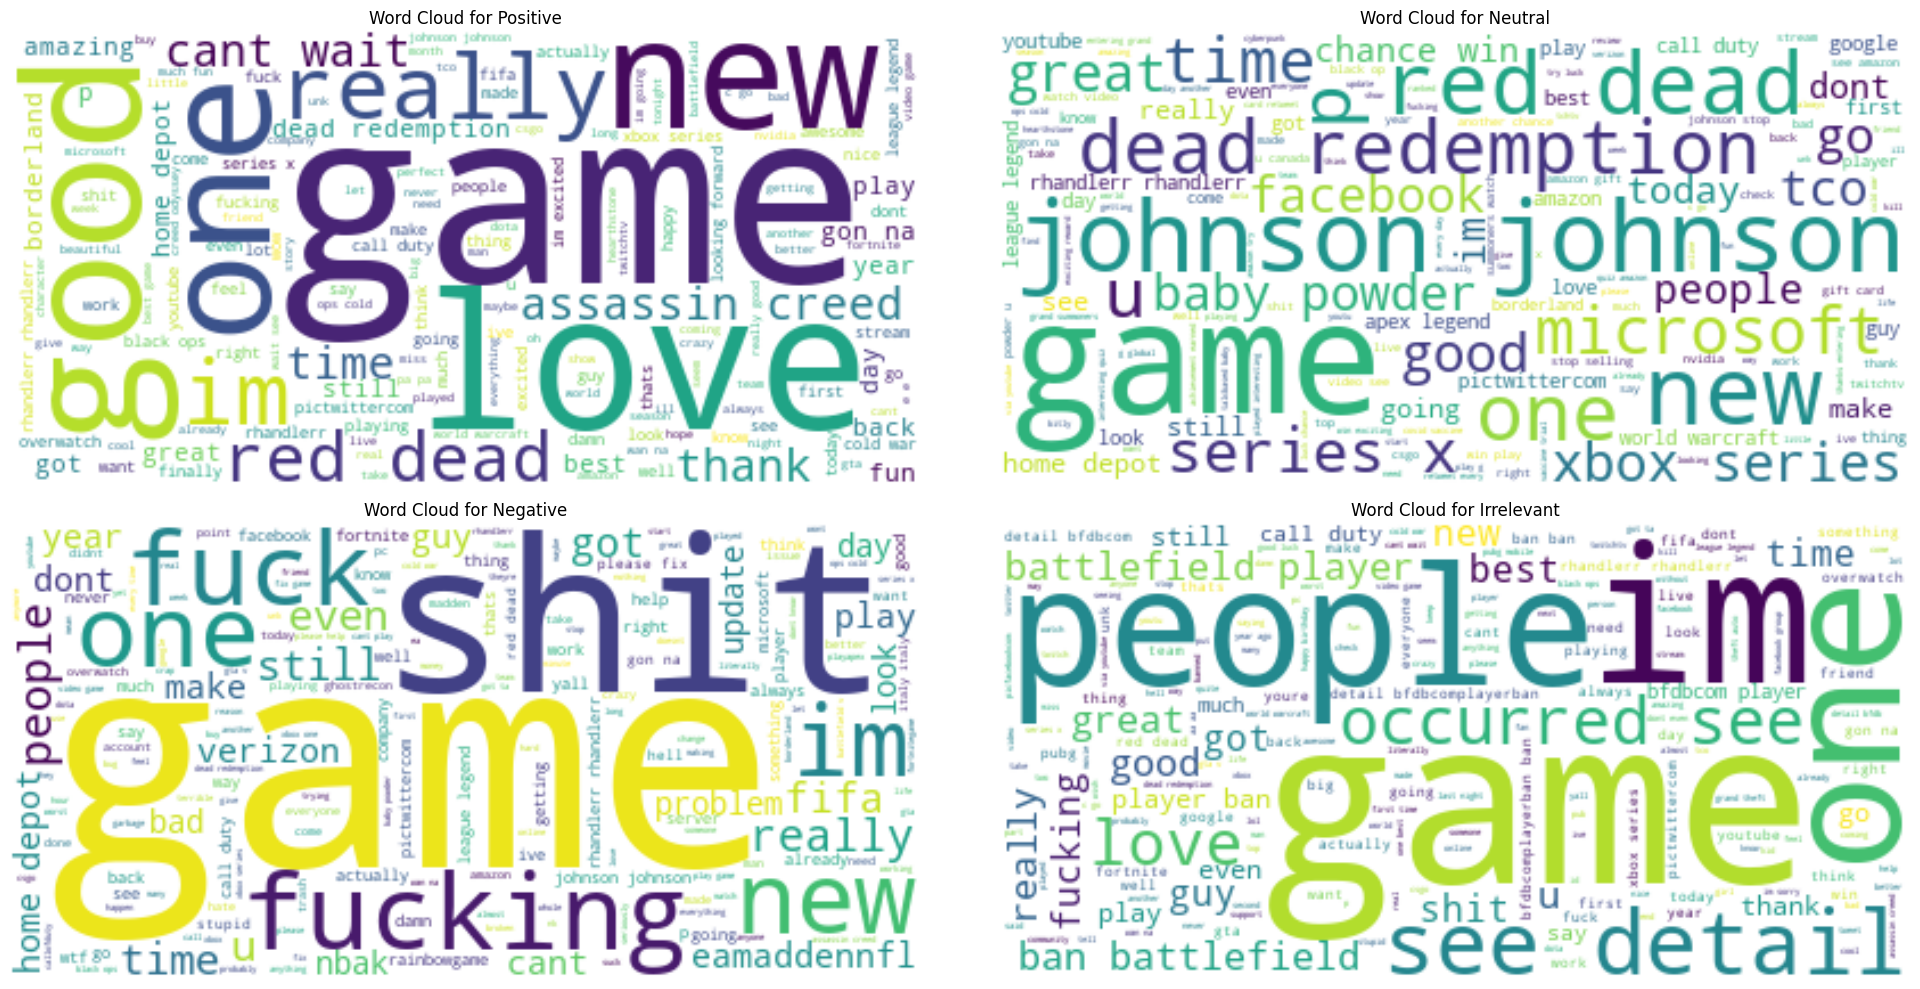

In [42]:
# Word Cloud
stopwords = set(STOPWORDS)
plt.figure(figsize=(20, 10))

for index, sentiment in enumerate(df['sentiment'].unique()):
    plt.subplot(2, 2, index + 1)
    sentiment_text = " ".join(df[df['sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(sentiment_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment}')
    plt.axis('off')

plt.tight_layout()
plt.show()

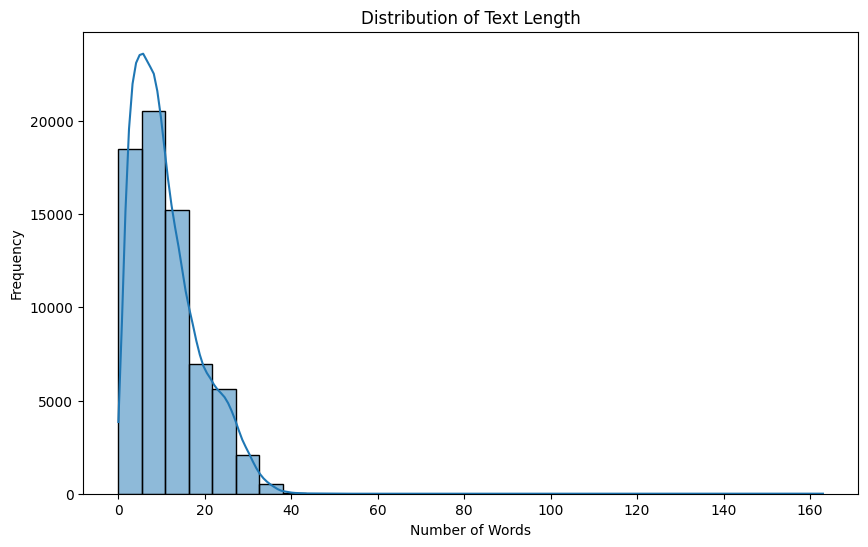

In [43]:
# Distribution of Text Length
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

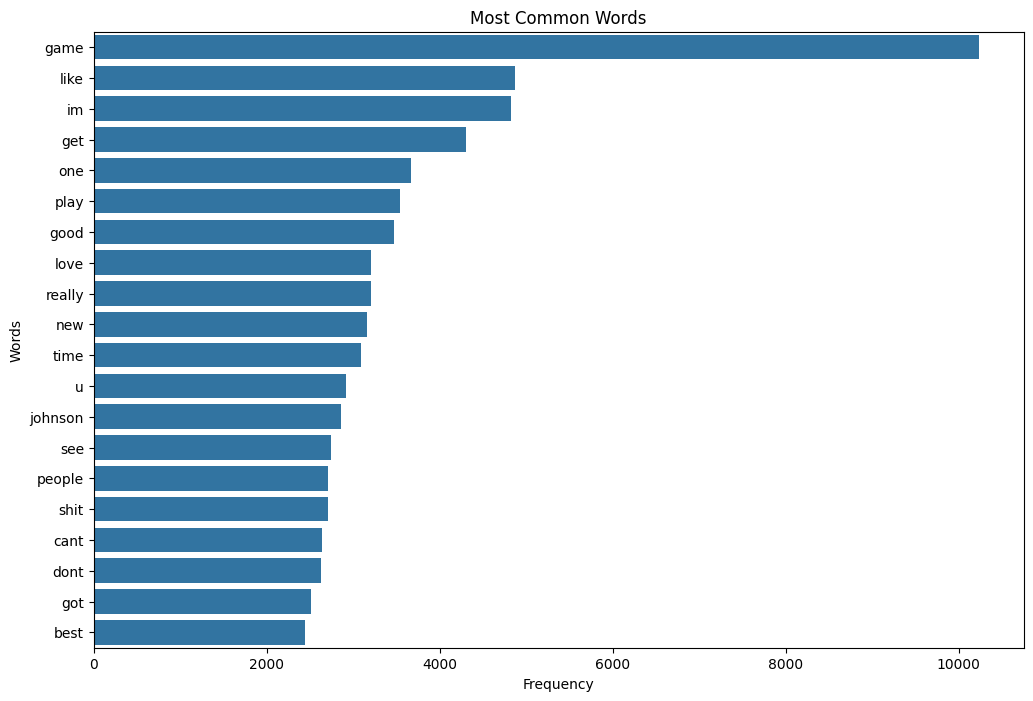

In [44]:
# Common Words Analysis
from collections import Counter

all_words = " ".join(df['cleaned_text']).split()
word_freq = Counter(all_words)

common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title('Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

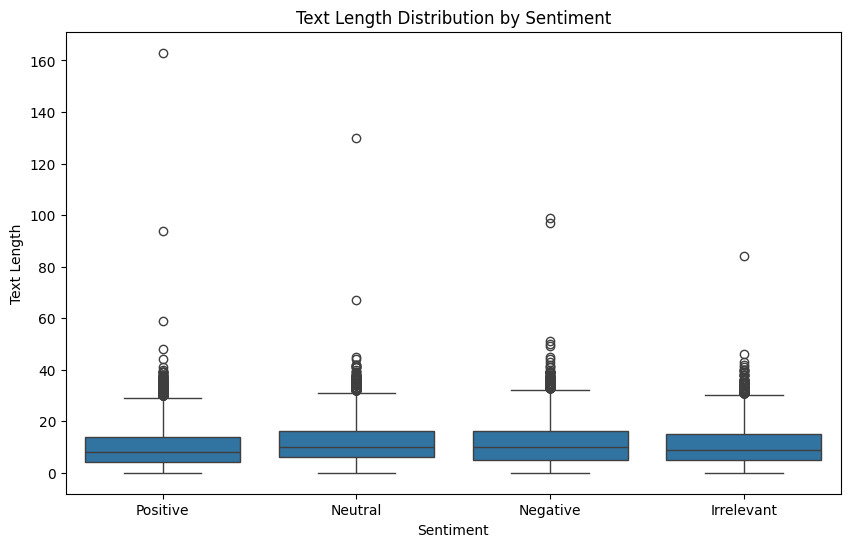

In [45]:
# Sentiment-wise Text Length Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

In [46]:
# Generate bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_text'])

# Display top 10 bigrams
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
print("Top 10 bigrams:", words_freq[:10])

Top 10 bigrams: [('game', 10238), ('like', 4867), ('im', 4819), ('get', 4304), ('one', 3665), ('play', 3539), ('good', 3471), ('love', 3210), ('really', 3207), ('new', 3165)]


In [47]:
# Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (69491, 1000)


In [48]:
# Sentiment analysis using TextBlob
df['polarity'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

print("Polarity and subjectivity features added:")
print(df[['cleaned_text', 'polarity', 'subjectivity']].head())

Polarity and subjectivity features added:
                   cleaned_text  polarity  subjectivity
0  im getting borderland murder       0.0           0.0
1            coming border kill       0.0           0.0
2    im getting borderland kill       0.0           0.0
3   im coming borderland murder       0.0           0.0
4  im getting borderland murder       0.0           0.0


In [49]:
# Handling imbalanced data using SMOTE
# Separate features and target
X = df[['cleaned_text', 'polarity', 'subjectivity']]
y = df['sentiment']

# Vectorize text data
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_text = tfidf_vectorizer.fit_transform(X['cleaned_text'])

# Combine text and sentiment features
X_combined = sp.hstack((X_text, X[['polarity', 'subjectivity']].values))

# Use SMOTE to handle imbalance
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_combined, y)

print("After resampling:")
print(pd.Series(y_resampled).value_counts())

After resampling:
sentiment
Positive      21166
Neutral       21166
Negative      21166
Irrelevant    21166
Name: count, dtype: int64


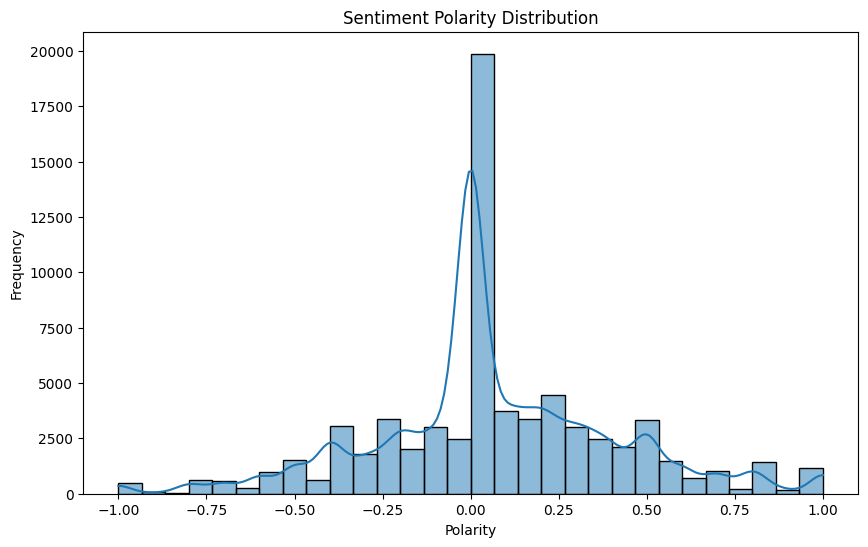

In [50]:
# Sentiment Polarity Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['polarity'], bins=30, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

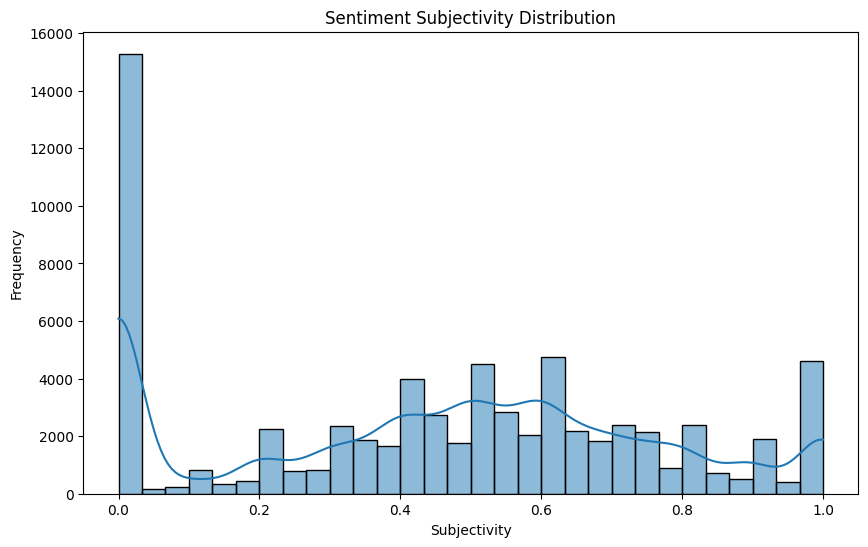

In [51]:
# Sentiment Subjectivity Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['subjectivity'], bins=30, kde=True)
plt.title('Sentiment Subjectivity Distribution')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.show()

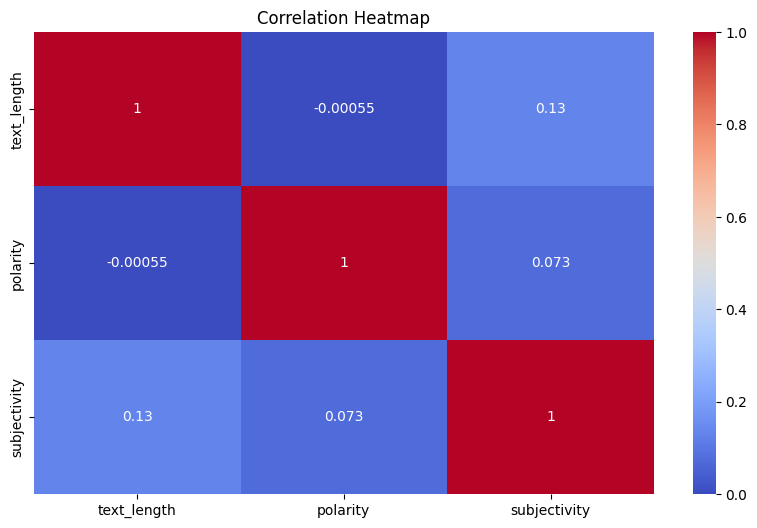

In [52]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = df[['text_length', 'polarity', 'subjectivity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf